# Hotel Cancellation Prediction

![banagil](https://github.com/frandiego/img/blob/master/algar-de-benagil.jpg?raw=true)

### Features 
* **is_canceled** . If the booking has been cancelled yes or no
* **lead_time** . Number of days that elapsed between the booking  the arrival date
* **hotel_type**. Resort or urban
* **arrival_date_year**. The year of the arrival (2015,2016 in train, 2017 in test)
* **arrival_date_month**. The month of the arrival
* **arrival_date_week_number**. The week number of the arrival  (1-53)
* **arrival_date_day** The day of the arrival (1-31)
* **stays_in_weekend_nights** Number of weekend nights (Sat,Sun) the guest booked at the hotel
* **stays_in_week_nights**  Number of weekend nights (Sat,Sun) the guest booked at the hotel
* **adults** Number of adults
* **children** Number of children
* **babies** Number of babies
* **meal** Type of meal booked. Categories are presented in standard hospitality meal packages:	
   * Undefined/SC – no meal package;
   * BB – Bed & Breakfast;
   * HB – Half board (breakfast and one other meal – usually dinner);
   * FB – Full board (breakfast, lunch and dinner)
* **country** Country of origin. Categories are represented in the ISO 3155–3:2013 format
* **market_segment** Market segment designation. In categories, the term 
  * TA means “Travel Agents” 
  * TO means “Tour Operators”
* **distribution_channel** Booking distribution channe. In categories, (like market segment) 
  * TA means “Travel Agents” 
  * TO means “Tour Operators”
* **is_repeated_guest** Value indicating if the booking name was from a repeated guest (1) or not (0)
* **previous_cancellations** Number of previous bookings not cancelled by the customer prior to the current booking
* **previous_booking_not_canceled** Number of previous bookings not cancelled by the customer prior to the current booking
* **reserved_room_type** Code of room type reserved. Code is presented instead of designation for anonymity reasons
* **assigned_room_type** Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons
* **booking_changes** Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
* **deposit_type** Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:
  * No Deposit means "no deposit was made"
  * Non Refund means "a deposit was made in the value of the total stay cost"
  * Refundable means "a deposit was made with a value under the total cost of stay"
  * **company** ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons
* **days_in_waiting_list** Number of days the booking was in the waiting list before it was confirmed to the customer
* **customer_type** Type of booking, assuming one of four categories:	
  * Contract - when the booking has an allotment or other type of contract associated to it;
  * Group – when the booking is associated to a group;
  * Transient – when the booking is not part of a group or contract, and is not associated to other transient booking;
  * Transient-party – when the booking is transient, but is associated to at least other transient booking
* **adr** Average Daily Rate as defined [here](https://en.wikipedia.org/wiki/Average_daily_rate)
* **required_car_parking_spaces** Number of car parking spaces required by the customer
* **total_of_special_requests** Number of special requests made by the customer (e.g. twin bed or high floor)
* **reservation_status** Reservation last status, assuming one of three categories:
  * Canceled – booking was canceled by the customer;
  * Check-Out – customer has checked in but already departed;
  * No-Show – customer did not check-in and did inform the hotel of the reason why
* **reservation_status_date** Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel

***

The PMS (hotels Property Management System) assured no missing data exists in its database tables. However, in some categorical variables like Agent or Company, “NULL” is presented as one of the categories. This should not be considered a missing value, but rather as “not applicable”. For example, if a booking “Agent” is defined as “NULL” it means that the booking did not came from a travel agent.

In [0]:
#@hidden
import pydot   
from IPython.display import Image

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz

from copy import deepcopy

## classification importance with and ExtraTreesClassifier
def classification_feature_importance(X,
                                      y,
                                      n_estimators=100, 
                                      criterion='gini',
                                      min_samples_split=2,
                                      min_samples_leaf=1,
                                      min_weight_fraction_leaf=0.,
                                      max_features='auto', 
                                      max_leaf_nodes=None,
                                      min_impurity_decrease=0.,
                                      min_impurity_split=1e-7, 
                                      bootstrap=True,
                                      oob_score=True,
                                      n_jobs=1, 
                                      random_state=0,
                                      verbose=0,
                                      class_weight=None):
    
    classifier = ExtraTreesClassifier(n_estimators=n_estimators, 
                                      criterion=criterion,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      min_weight_fraction_leaf=min_weight_fraction_leaf,
                                      max_features=max_features, 
                                      max_leaf_nodes=max_leaf_nodes,
                                      min_impurity_decrease=min_impurity_decrease,
                                      min_impurity_split=min_impurity_split, 
                                      bootstrap=bootstrap,
                                      oob_score=oob_score,
                                      n_jobs=n_jobs, 
                                      random_state=random_state,
                                      verbose=verbose,
                                      class_weight=class_weight)
    classifier.fit(X,y)
    df_importance = pd.DataFrame({'feature':list(X.columns),
                                  'importance':list(classifier.feature_importances_)})
    df_importance.sort_values('importance',inplace=True,ascending=False)
    return df_importance



## plot a tree
def plot_tree(estimator,features_names):
    dot_data = StringIO()  
    export_graphviz(estimator, 
                    out_file=dot_data,
                    feature_names=features_names,
                    filled=True,rounded=True)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph[0].create_png())  

## find correlations

def take_most_correlated(df,correlation_threshold = 0.9):
    aux = df.corr()[(df.corr()>=correlation_threshold)].reset_index().melt('index').dropna()
    aux = aux[aux['index'] != aux['variable']]
    aux['var_left'],aux['var_right'] = aux.apply(lambda r:sorted([r['index'],r['variable']]),axis=1).str
    aux = aux.loc[:,['var_left','var_right','value']].drop_duplicates()
    var_list = list(aux['var_left'].values) + list(aux['var_right'].values)
    return pd.Series(var_list).value_counts(normalize=True)



## map encoder
def map_encoder_categorical(x):
    set_ = sorted(set(x))
    range_ = list(range(1,len(set_)+1))
    return dict(zip(set_,range_))

def map_encoder_fit(df,categorical_features):
    return {i:map_encoder_categorical(df[i]) for i in categorical_features}

def map_encoder_transform(df,map_encoder):
    df_ = deepcopy(df) 
    for i in map_encoder.keys():
        map_encoder_variable = map_encoder[i]
        fill_ = int(max(map_encoder_variable.values()) + 1)
        df_[i] = df_[i].map(map_encoder_variable).fillna(fill_).astype(int)
    return df_

## onehot encoder
def onehot_encoder_fit(df,columns):
    dict_ = {}
    dict_['categorical_columns'] = columns
    dict_['output_columns'] = list(pd.get_dummies(data=df,columns=columns).columns)
    return dict_

def onehot_encoder_transform(df,onehot_encoder):
    df_ = deepcopy(df)
    df_ = pd.get_dummies(data=df_,columns=onehot_encoder['categorical_columns'])
    df_ = df_.loc[:,onehot_encoder['output_columns']].fillna(0)

In [0]:
import pandas as pd
import numpy as np
from plotnine import *
import warnings
from datetime import datetime
import plotly.express as px
# from tools import *
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

# 1. Read Train Data

In [0]:
path = 'https://raw.githubusercontent.com/frandiego/data/master/hotel_cancellation_train.csv'
df = pd.read_csv(path)

In [0]:
df = df.drop(['reservation_status','reservation_status_date'],axis=1)

# 2. Explore

## 2.1 Explore Continuous

#### Density plotof `lead_time` separated by `is_cancelled`

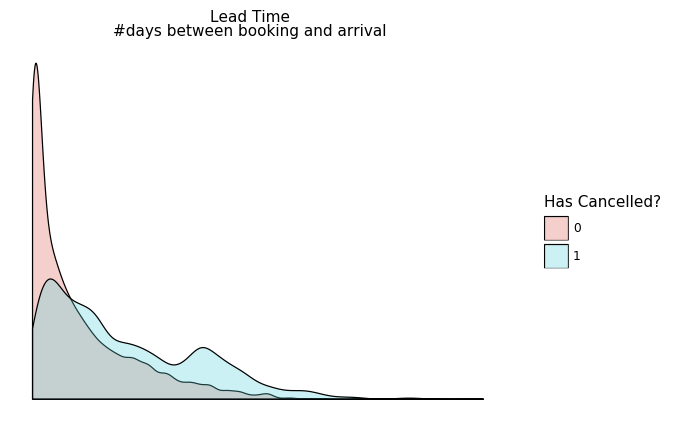

<ggplot: (-9223363245501302489)>

In [0]:
ggplot(df,aes(x='lead_time')) +\
geom_density(aes(fill='factor(is_cancelled)'),alpha=0.3) +\
theme_void()+\
labs(title = 'Lead Time\n#days between booking and arrival', fill='Has Cancelled?')

#### Scatter plot of `lead_time` and `adr` separated by `is_cancelled`

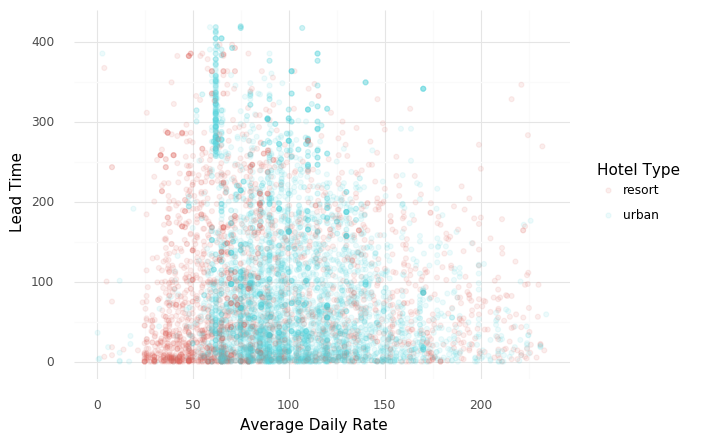

<ggplot: (-9223363245502904267)>

In [0]:
ggplot(df.sample(frac=0.1),aes(x= 'adr',y = 'lead_time')) +\
geom_point(aes(color='factor(hotel_type)'),alpha=0.1)+\
ylim([0.001,df['lead_time'].quantile(0.99)])+\
xlim([0.001,df['adr'].quantile(0.99)]) +\
theme_minimal() +labs(color='Hotel Type',y='Lead Time', x = 'Average Daily Rate')

## 2.2 Explore Categorical

#### STD Plot of categorical variables by   `is_cancelled`. I have consider a variable to be categorical is the lenght of unique values is lower or equal than 160

In [0]:
category_columns = df.columns[(df.nunique()<=160)].tolist()
dfplot = df[category_columns].melt('is_cancelled')
dfplot = dfplot.groupby(['variable','value']).agg(mean = ('is_cancelled','mean')).reset_index()
dfplot = dfplot.groupby(['variable']).agg(std = ('mean','std')).reset_index()
dfplot = dfplot.sort_values('std')  
dfplot['variable'] = pd.Categorical(dfplot['variable'],categories=dfplot['variable'].unique())

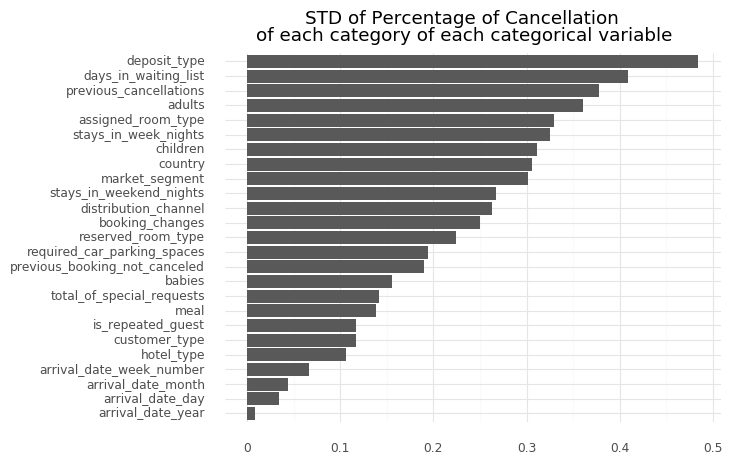

<ggplot: (8791351527495)>

In [0]:
ggplot(dfplot,aes(x='variable',y='std')) +\
geom_col() + \
coord_flip() + \
theme_minimal()+\
labs(x='',y='',title='STD of Percentage of Cancellation \nof each category of each categorical variable')


## 2.3 Explore the time Series

#### Time Series plot of `adr` by time and `hote_type`. To do so you need first to create a date column using `arrival_date_day`, `arrival_date_month` and `arrival_date_year` then you can use `strptime` from `datetime` with the format `%d-%B-%Y` for example ...

In [0]:
df['arrival_date'] = df.apply(lambda r:
                                         str(r['arrival_date_day']).zfill(2) + '-' +
                                         str(r['arrival_date_month']) + '-'+
                                         str(r['arrival_date_year']),axis=1)

In [0]:
df['arrival_date'] = df['arrival_date'].apply(lambda i:datetime.strptime(i,'%d-%B-%Y'))

In [0]:
aux = df.groupby(['arrival_date','hotel_type']).agg(n=('adr','mean')).reset_index()

In [0]:
ggplot(aux,aes(x='arrival_date',y='n',color='factor(hotel_type)')) +\
geom_point(alpha=0.1) +\
geom_smooth(method='loess')+ theme_minimal()+theme(legend_position='top',figure_size=(15,5)) +\
labs(x='',y='Average Daily Rage',color='Hotel Type')

PlotnineError: ignored

# 3. Feature Engineering

In [0]:
label_clf = 'is_cancelled'
label_rgs = 'adr'
remove = ['arrival_date','arrival_date_year']
features = [i for i in df.columns if i not in [label_clf,label_rgs] + remove]
X,y_clf,y_rgs = df[features],df[label_clf],df[label_rgs]

## 3.1 Create the variable `assigned_reserved_room_type` that is 1 when  `assigned_room_type` is the `reserved_room_type` and 0 when is not

In [0]:
X['assigned_reserved_room_type'] = (X['assigned_room_type'] == X['reserved_room_type']).astype(int)

## 3.2. The `arrival_date_month` has been collected in character (January, February...), so coerce them to be an integer but with the information of the order
```python
months = ['January','February','March','April','May',
          'June','July','August','September', 'October',
          'November','December']
```

In [0]:
months = ['January','February','March','April','May',
          'June','July','August','September', 'October',
          'November','December']
months_dict = {v:i for i,v in enumerate(months)}
months_dict

{'April': 3,
 'August': 7,
 'December': 11,
 'February': 1,
 'January': 0,
 'July': 6,
 'June': 5,
 'March': 2,
 'May': 4,
 'November': 10,
 'October': 9,
 'September': 8}

In [0]:
X['arrival_date_month']= X['arrival_date_month'].map(months_dict)

## 3.3 Let's select numeric features , create a `map_encode` with the rest of them

In [0]:
features = ['hotel_type','country','meal','market_segment','distribution_channel',
            'reserved_room_type','assigned_room_type','deposit_type','agent','company','customer_type']

In [0]:
map_encoder = map_encoder_fit(X,features)

TypeError: ignored

## 3.4 Create a function `transform` that given the raw-data returns the transformed_data

In [0]:
def transform(df,map_encoder):
    X = deepcopy(df)
    remove = ['adr','is_cancelled','reservation_status','reservation_status_date','arrival_date_year']
    X.drop(remove,axis=1,inplace=True)
    X['assigned_reserved_room_type'] = (X['assigned_room_type'] == X['reserved_room_type']).astype(int)
    months = ['January','February','March','April','May',
          'June','July','August','September', 'October',
          'November','December']
    months_dict = {v:i for i,v in enumerate(months)}
    X['arrival_date_month']= X['arrival_date_month'].map(months_dict)
    return map_encoder_transform(X,map_encoder)
    

## 3.5. Apply transform to train and test. Read the data and take:
* `X_train`
* `y_train_cancel`
* `y_train_adr`
* `X_test`
* `y_test_cancel`
* `y_test_adr`

In [0]:
path_train = 'https://raw.githubusercontent.com/frandiego/data/master/hotel_cancellation_train.csv'
path_test =  'https://raw.githubusercontent.com/frandiego/data/master/hotel_cancellation_test_all.csv'

In [0]:
df = pd.read_csv(path_train)
X_train = transform(df,map_encoder)
y_train_cancel = df['is_cancelled']
y_train_adr = df['adr']

In [0]:
df = pd.read_csv(path_test)
X_test = transform(df,map_encoder)
y_test_cancel = df['is_cancelled']
y_test_adr = df['adr']

# 4. Predict Average Daily Rate

In [0]:
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import *

def reg_metrics(model):
    model.fit(X_train.fillna(0),y_train_adr)
    y_pred_adr = model.predict(X_test)
    print('R2  : ',np.round(r2_score(y_test_adr,y_pred_adr),3))
    print('RMSE: ',np.round(np.sqrt(mean_squared_error(y_test_adr,y_pred_adr)),3))


In [0]:
%%time
reg_metrics(HistGradientBoostingRegressor(random_state=101))

In [0]:
y_pred_adr = HistGradientBoostingRegressor(random_state=101).fit(X_train,y_train_adr).predict(X_test)

In [0]:
aux = pd.DataFrame({'adr':y_test_adr,'pred':y_pred_adr,'is_cancelled':y_test_cancel})

In [0]:
ggplot(aux,aes(x='adr',y='pred')) + geom_point(aes(color='factor(is_cancelled)'),alpha=0.05) + theme_minimal()

In [0]:
ggplot(aux.melt('is_cancelled'),aes('value')) +\
geom_density(fill='black') + facet_grid(('is_cancelled','variable')) + theme_minimal()

In [0]:
ggplot(aux.melt('is_cancelled'),aes('value')) +\
geom_density(aes(fill='factor(variable)'),alpha=0.3) + facet_wrap('is_cancelled') + theme_minimal()

In [0]:
aux['error'] = aux['adr'] - aux['pred']

In [0]:
ggplot(aux.reset_index(),aes('index','error')) + \
geom_point(alpha=0.1) + theme_minimal() + \
geom_smooth(color='red') 

# 5. Predict if the book is going to be cancelled
### If the predicion of ADR is good enough, you can use the adr predicted as a new feature

In [0]:
X_train['adr'] = HistGradientBoostingRegressor(random_state=101).fit(X_train,y_train_adr).predict(X_train)

In [0]:
X_test['adr'] = HistGradientBoostingRegressor(random_state=101).fit(X_train.drop('adr',axis=1),y_train_adr).predict(X_test)

In [0]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
from sklearn.neural_network import MLPClassifier 
from lightgbm import LGBMClassifier
model = MLPClassifier(random_state=101)
def metrics_clf(model):
    model.fit(X_train.fillna(0),y_train_cancel)
    y_pred = model.predict(X_test)
    print('AUC    : ', np.round(roc_auc_score(y_test_cancel,y_pred),3))
    print('Kappa  : ', np.round(cohen_kappa_score(y_test_cancel,y_pred),3))
    print(classification_report(y_test_cancel,y_pred))
    return model

In [0]:
%%time
model = metrics_clf(LGBMClassifier(random_state=101,class_weight='balanced'))

In [0]:
from lightgbm import plot_importance

In [0]:
plot_importance(model.booster_,figsize=(20,10))

In [0]:
from yellowbrick.classifier import ROCAUC
model = LGBMClassifier(class_weight='balanced',random_state=101)
visualizer = ROCAUC(model, classes=[0,1])
visualizer.fit(X_train, y_train_cancel)     
visualizer.score(X_test, y_test_cancel)    
visualizer.show() 
print('AUC    : ', np.round(roc_auc_score(y_test_cancel,model.predict(X_test)),3))
print(classification_report(y_test_cancel,model.predict(X_test)))